# ANSI Application analysis

In [1]:
import numpy
import pandas
import matplotlib
import matplotlib.pyplot as plotter
from scipy.stats import pearsonr, probplot
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
def view_boxplot(df):
    %matplotlib
    df.boxplot()
    plotter.show()

## CPU data

In [3]:
cpu_df = pandas.read_csv('data/ansi_final/ansi_final_cpu.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [4]:
#cpu_df.columns

In [5]:
cpu_df = cpu_df.clip(lower=0, upper=1000)
#view_boxplot(cpu_df)

## Network TX

In [6]:
txnet_df = pandas.read_csv('data/ansi_final/ansi_final_network_tx.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [7]:
#txnet_df.columns

In [8]:
txnet_df = txnet_df.clip(lower=0, upper=50000)
#view_boxplot(txnet_df)

## Network RX

In [9]:
rxnet_df = pandas.read_csv('data/ansi_final/ansi_final_network_rx.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [10]:
#rxnet_df.columns

In [11]:
rxnet_df = rxnet_df.clip(lower=0, upper=15000)
#view_boxplot(rxnet_df)

## Disk IO data

In [12]:
disk_df = pandas.read_csv('data/ansi_final/ansi_final_disk_io.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [13]:
#disk_df.columns

In [14]:
disk_df = disk_df.clip(lower=0, upper=4000)
#view_boxplot(disk_df)

## Context switching

In [15]:
context_df = pandas.read_csv('data/ansi_final/ansi_final_context.csv', index_col='Time').drop('Unnamed: 0', axis=1)

In [16]:
#context_df.columns

In [17]:
context_df = context_df.clip(lower=0, upper=5000)
#view_boxplot(context_df)

## Seperate into proper dataframes for each node

In [18]:
dframes = [cpu_df, txnet_df, rxnet_df, context_df, disk_df]
node = {}

for i in range(1,13):
    frames = []
    
    for dframe in dframes:
        columns = list(filter(lambda x: f'bb{i}l' in x, dframe.columns))
        frames.append(dframe[columns])

    node[i] = pandas.concat(frames, join='inner', axis=1).fillna(0)[:68300]

In [19]:
for i in range(1,13):
    print(node[i].shape)
    
for i in range(len(node[1].columns)):
    print(f"{i}: {node[1].columns[i]}")

(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
(68300, 29)
0: cpu_value host bb1localdomain type_instance idle
1: cpu_value host bb1localdomain type_instance interrupt
2: cpu_value host bb1localdomain type_instance nice
3: cpu_value host bb1localdomain type_instance softirq
4: cpu_value host bb1localdomain type_instance steal
5: cpu_value host bb1localdomain type_instance system
6: cpu_value host bb1localdomain type_instance user
7: cpu_value host bb1localdomain type_instance wait
8: interface_tx host bb1localdomain instance lo type if_dropped
9: interface_tx host bb1localdomain instance lo type if_errors
10: interface_tx host bb1localdomain instance lo type if_octets
11: interface_tx host bb1localdomain instance lo type if_packets
12: interface_tx host bb1localdomain instance wlan0 type if_dropped
13: interface_tx host bb1localdomain instance wlan0 type if_errors
14: interface_tx host bb1localdomain i

## Get data

In [20]:
data_matrices = []

for i in range(1,13):
    data_matrices.append(node[i].as_matrix())
    
data = numpy.vstack(data_matrices)

In [21]:
data.shape

(819600, 29)

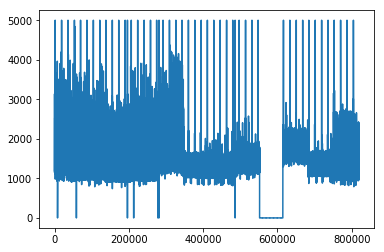

(819600, 29)


In [22]:
tdata = data[:,24]
plotter.plot(tdata.T)
plotter.show()
print(data.shape)

In [23]:
#data = data[:,24]

## Prepare scaler

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scaler = MinMaxScaler()

In [25]:
scaler.fit(data)
del data

---

## Correrlation measurement

---

------

-----

In [26]:
for i in range(len(data_matrices)):
    
    transformed = scaler.transform(data_matrices[i])
    data_matrices[i] = transformed

X = numpy.stack(data_matrices[:4], axis=1)
test = numpy.stack(data_matrices[4:], axis=1)
print(X.shape)
print(test.shape)

(68300, 4, 29)
(68300, 8, 29)


In [27]:
print(X.shape)
LEN = X.shape[0]
SPLIT = int(0.8*LEN)

train_X = X[:SPLIT,:,:]
val_X = X[SPLIT:,:,:]

print(train_X.shape)
print(val_X.shape)

(68300, 4, 29)
(54640, 4, 29)
(13660, 4, 29)


In [28]:
test_X = numpy.transpose(test, (1,0,2))
train_X = numpy.transpose(train_X, (1,0,2))
val_X = numpy.transpose(val_X, (1,0,2))
print(test_X.shape)
print(train_X.shape)
print(val_X.shape)

(8, 68300, 29)
(4, 54640, 29)
(4, 13660, 29)


In [29]:
def flat_generator(X, tsteps = 5, ravel=1):
    i = 0
    
    while True:
        batch_X = X[:,i:i+tsteps,:]
        batch_y = X[:,i+tsteps,:]
            
        if ravel:
            batch_X = batch_X.reshape((batch_X.shape[0], -1))
        #print(batch_X.shape)
        #print(batch_y.shape)
        
        yield batch_X, batch_y
        
        i += 1
        if i > (X.shape[1] - tsteps - 1):
            i = 0
            continue

(68300,)


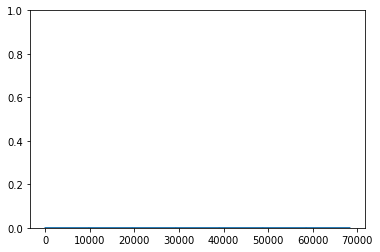

3


In [30]:
series = test_X[7,:,21]
print(series.shape)
plotter.ylim(0,1)
plotter.plot(series)
plotter.show()
print(numpy.random.randint(29))

In [31]:
avg_load = test_X[3,:,:]
disk_io_start_late = test_X[0,:,:]
app_change_early = test_X[1,:,:]
idle_early = test_X[4,:,:]
normal_test = test_X[7,:,:]
synth_test = test_X[7,3000:10000,:]

(7000, 29)


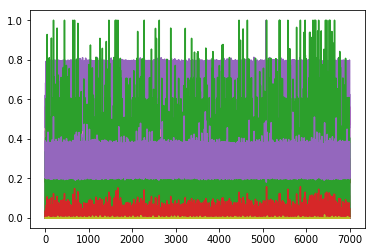

In [32]:
print(synth_test.shape)
plotter.plot(synth_test[:,:])
plotter.show()

In [33]:
def get_anomaly_labels(error, window_size, technique):
    
    if technique == "rolling":
        arr = pandas.Series(error)
        means = arr.rolling(window=window_size).mean()
        std = arr.rolling(window=window_size).std()
        
    if technique == "exp":
        arr = pandas.Series(error)
        means = arr.ewm(halflife=window_size).mean()
        std = arr.ewm(halflife=window_size).std()
        
    outlier = (arr > (means + (5.0 * std))) * 1.0
    mark = numpy.zeros(arr.shape[0])
    
    window = 100

    for i in range(window,outlier.shape[0]):
        num = window
        outliers = numpy.sum(outlier[i-window:i])
        per = outliers/num
        if per > 0.04:
            mark[i-window:i] = outlier[i-window:i]
        else:
            mark[i] = 0.0
            
    #plotter.plot(0.09 * true,'r-', alpha=0.5, label="True")
    plotter.plot(0.09 * mark,'b-', alpha=0.3, label="Prediction", linewidth=1)
    plotter.plot(means,'b--', alpha=0.9, linewidth=0.5)
    plotter.plot(means + (5.0 * std), 'r-', alpha=0.5, linewidth=0.5)
    plotter.plot(error,'g-', alpha=0.5, label="Error", linewidth=0.5)
    plotter.ylim(0,0.1)
    plotter.legend()
    plotter.show()
            
    return mark

def get_score(error, true, moving_window, name="none", dataset_name="none"):
    
    # For rolling window
    labels = get_anomaly_labels(error, moving_window, "rolling")
    true = true[true.shape[0]-labels.shape[0]:]
    #print(true)
    #print(labels)
    
    plotter.plot(0.09 * true,'r-', alpha=0.5, label="True")
    plotter.plot(0.09 * labels,'b-', alpha=0.5, label="Prediction")
    plotter.plot(error,'g-', alpha=0.3, label="Error")
    plotter.ylim(0,0.1)
    plotter.legend()
    plotter.show()
    
    print(f"For {name} and rolling window size {moving_window} and dataset name {dataset_name}, F1 score is {f1_score(true, labels)}")
    print(f"True: {numpy.sum(true)} Labels: {numpy.sum(labels)} Overlap: {numpy.sum(numpy.logical_and(true, labels) * 1.0)}")
    
    # For exp window
    labels = get_anomaly_labels(error, moving_window, "exp")
    true = true[true.shape[0]-labels.shape[0]:]
    
    plotter.plot(0.09 * true,'r-', alpha=0.5, label="True")
    plotter.plot(0.09 * labels,'b-', alpha=0.5, label="Prediction")
    plotter.plot(error,'g-', alpha=0.3, label="Error")
    plotter.ylim(0,0.5)
    plotter.legend()
    plotter.show()
    
    print(f"For {name} and exp window size {moving_window} and dataset name {dataset_name}, F1 score is {f1_score(true, labels)}")
    print(f"True: {numpy.sum(true)} Labels: {numpy.sum(labels)} Overlap: {numpy.sum(numpy.logical_and(true, labels) * 1.0)}")
    
def get_error(model ,dataset, ravel=1, name="none", window=10):
    
    test_gen = flat_generator(numpy.array([dataset]), window,0)
    error = []
    targets = []
    preds = []
    for i in range(dataset.shape[0]-(window+1)):
        _input,target = next(test_gen)
        targets.append(target.squeeze())
        #print(_input.shape)
        if ravel:
            _input = _input.ravel()[:,numpy.newaxis].T
            
        pred = model.predict(_input)
        #print(target.shape)
        #print(pred.shape)
        preds.append(pred.squeeze())
        error.append(mean_absolute_error(y_pred=pred, y_true=target))

    targets = numpy.vstack(targets)
    preds = numpy.vstack(preds)
    differences = numpy.abs(targets-preds)
    
    plotter.plot(numpy.array(error), alpha=0.5, linewidth=0.5, label="error")
    plotter.ylim(0,0.1)
    plotter.legend()
    plotter.plot()
    plotter.show()

    return error, differences


def test_anomalies(model, dataset, ravel=1, windows_list=[100], name="none", window=10):
    
    
    for window_size in windows_list:
        
        ## For network flood:
        
        for i in range(9,10):
            
            test_set = numpy.copy(dataset)
            anomaly_range = numpy.random.randint(3000,5000)
            test_set[anomaly_range:anomaly_range+i,21:23] = 1.0
            true = numpy.zeros(test_set.shape[0])
            true[anomaly_range:anomaly_range+i] = 1.0
        
            error, differences = get_error(model, test_set, ravel, window=window)
            error = numpy.array(error)
            print(error.shape)
            print(differences.shape)
            
            marks = get_anomaly_labels(error, 720, "exp")
            print(marks)
            #fname = f"results/{name}_{window_size}_duration_{i}.npy"
            #print(f"Writing {fname}")
            #numpy.save(fname,error)
            #numpy.save(f"results/{name}_{window_size}_duration_{i}_true.npy",true)
            #get_score(error, true, window_size, name, "network_flood")
        
        
        #noise = numpy.random.normal(size=test_set.shape, loc=0, scale=0.1)
        
        #test_set = numpy.clip(test_set + noise, a_min=0.0, a_max=1.0)
        
        
        #(test_set.shape)
        
        
    

## Training functions

In [34]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, GRU
from keras.callbacks import EarlyStopping

/home/adityas/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [35]:
def train(model, tgen, vgen, name="none"):
    estopper = EarlyStopping(patience=15, min_delta=0.0001)
    history = model.fit_generator(tgen, steps_per_epoch=1000, epochs=10000, callbacks=[estopper], shuffle=False, validation_data=vgen, validation_steps=1000, verbose=0)
    plotter.plot(history.history['loss'],label='train')
    plotter.plot(history.history['val_loss'],label='validation')
    plotter.legend()
    #plotter.xlim(0,150)
    plotter.xlabel("Epochs")
    plotter.ylabel("Error")
    plotter.savefig(f"{name}_train.png", dpi=500)
    plotter.show()
    print(f"Training loss for final epoch is {history.history['loss'][-1]}")
    print(f"Validation loss for final epoch is {history.history['val_loss'][-1]}")

In [48]:
def plot_running_stats(error, name="none", window_size=5, bounds=None, qq=0):
    error = numpy.array(error)
    #numpy.save(f"results/{name}_error.npy", error)
    window = numpy.ones(window_size)/window_size
    running_mean = numpy.convolve(error, window, mode="same")
    running_sigma = pandas.Series(error).rolling(window=window_size, center=True).std()
    difference = 3.0 * running_sigma
    
    upper = running_mean + difference
    lower = running_mean - difference
    
    if bounds == None:
        global_mean = numpy.mean(error) * numpy.ones(error.shape[0])
        global_sigma = numpy.std(error) * numpy.ones(error.shape[0])
        bound = (5.0 * global_sigma) + global_mean
        
    else:
        
        global_mean = bounds[0]
        bound = bounds[1]
        
    anomaly = ((error > bound) * error)
    anomaly = numpy.array([float('nan') if x == 0.0 else x for x in anomaly])
    
    if qq:
        
        #a, b, l, s = beta.fit(error)
        probplot(error,dist="norm", plot=plotter)
        plotter.legend()
        plotter.savefig(f"{name}_qq.png",dpi=500)
        plotter.show()
        
        plotter.hist(error, bins=100)
        plotter.legend()
        plotter.savefig(f"{name}_hist.png")
        plotter.show()
    
    arr = pandas.Series(error)
    means = arr.rolling(window=720).mean()
    std = arr.rolling(window=720).std()
    outlier = (arr > (means + 5.0 * std)) * 1.0

    mark = numpy.ones(arr.shape[0]) * numpy.nan

    window = 100

    for i in range(window,outlier.shape[0]):
        num = window
        outliers = numpy.sum(outlier[i-window:i])
        per = outliers/num
        if per > 0.04:
            mark[i-window:i] = 1.0
        else:
            mark[i] = 0.0
    
    plotter.plot(error, 'g-', label="Error", alpha=0.4, linewidth=0.5)
    plotter.ylim(0,0.2)
    plotter.xlabel("time")
    plotter.ylabel("Error")
    plotter.legend()
    plotter.savefig(f"{name}_error_plain.png", dpi=500)
    plotter.show()
    
    fig = plotter.figure()
    plotter.plot(error, 'g-', alpha=0.4, label="Error", linewidth=0.5)
    plotter.plot(means, 'r-.', alpha=0.9, label="Mean", linewidth=0.5)
    #plotter.plot(upper,'b-', alpha=0.2, label="Upper Bound", linewidth=0.5)
    plotter.plot(means + 5.0 * std,'b--', alpha=0.9, label="Bound", linewidth=0.5)
    plotter.plot(0.1 * mark,'r-', alpha=0.5, label="Anomaly")
    plotter.legend()
    plotter.ylim(0,0.2)
    plotter.xlim(40000,50000)
    plotter.xlabel("time")
    plotter.ylabel("Error")
    plotter.draw()
    fig.savefig(f"{name}_truetestloss.png", dpi=500)
    plotter.show()
    
    
    
    arr = pandas.Series(error)
    means = arr.ewm(halflife=720).mean()
    std = arr.ewm(halflife=720).std()
    outlier = (arr > (means + 5.0 * std)) * 1.0

    mark = numpy.ones(arr.shape[0]) * numpy.nan

    window = 100

    for i in range(window, outlier.shape[0]):
        num = window
        outliers = numpy.sum(outlier[i-window: i])
        per = outliers/num
        if per > 0.04:
            mark[i] = 1.0
        else:
            mark[i] = 0.0
    
    fig = plotter.figure()
    plotter.plot(error, 'g-', alpha=0.4, label="Error", linewidth=0.5)
    plotter.plot(means, 'r-.', alpha=0.9, label="Mean", linewidth=0.5)
    #plotter.plot(upper,'b-', alpha=0.2, label="Upper Bound", linewidth=0.5)
    plotter.plot(means + 5.0 * std,'b--', alpha=0.9, label="Bound", linewidth=0.5)
    plotter.plot(0.1 * mark,'r-', alpha=0.5, label="Anomaly")
    plotter.legend()
    plotter.ylim(0,0.2)
    plotter.xlim(40000,50000)
    plotter.xlabel("time")
    plotter.ylabel("Error")
    plotter.draw()
    fig.savefig(f"{name}_truetestloss_exp.png", dpi=500)
    plotter.show()
    
    
    fig.clf()
    plotter.clf()
    plotter.close()
    error = numpy.array(error)
    print(f"The mean error for {name} is {numpy.mean(error)} for length {error.shape[0]}")
    
    return (global_mean, bound)

In [37]:
def data_test(model, dataset=test_X[0], ravel=1, write=0, name="none", window=5, bounds=None, qq=0):
    test_gen = flat_generator(numpy.array([dataset]), window,0)
    error = []
    targets = []
    preds = []
    for i in range(dataset.shape[0]-(window+1)):
        _input,target = next(test_gen)
        targets.append(target.squeeze())
        if ravel:
            _input = _input.ravel()[:,numpy.newaxis].T
            
        pred = model.predict(_input)
        #print(target.shape)
        #print(pred.shape)
        preds.append(pred.squeeze())
        error.append(mean_absolute_error(y_pred=pred, y_true=target))

    targets = numpy.vstack(targets)
    preds = numpy.vstack(preds)
    return plot_running_stats(error, name=name, window_size=window, bounds=bounds, qq=qq)
    #return None
    #print(error)

In [38]:
def gen_test(model, dataset=test_X[0], ravel=1, write=0, name="none"):
    test_gen = flat_generator(numpy.array([dataset]), TIMESTEPS,0)
    error = []
    targets = []
    preds = []
    for i in range(2000):
        _input,target = next(test_gen)
    
        if i != 0:
            #print(_input.shape)
            _input = _input.squeeze()[1:,:]
            #print(_input.shape)
            _input = numpy.append(pred,_input, axis=0)[numpy.newaxis,:,:]
            #print(_input.shape)
        
        targets.append(target.squeeze())
        if ravel:
            _input = _input.ravel()[:,numpy.newaxis].T
            
        pred = model.predict(_input)
        #print(target.shape)
        #print(pred.shape)
        preds.append(pred.squeeze())
        error.append(mean_absolute_error(y_pred=pred, y_true=target))

    targets = numpy.vstack(targets)
    preds = numpy.vstack(preds)

    plotter.plot(error, 'g-', alpha=0.5)
    plotter.ylim(0,0.2)
    plotter.xlabel("time")
    plotter.ylabel("Error")
    plotter.savefig(f"{name}_testloss.png")
    plotter.show()
    error = numpy.array(error)
    print(numpy.mean(error))
    plotter.boxplot(error)
    plotter.ylim(0,0.2)
    plotter.xlabel("time")
    plotter.ylabel("Error")
    plotter.savefig(f"{name}_boxplot.png")
    plotter.show()
    if write:
        numpy.savetxt('loss.txt', numpy.array(error))
    true_test(model,dataset,ravel=ravel,name=name)
    #print(error)

In [46]:
def test(model, ravel=1, name="none", window=20):
    print(f"---------- Beginning tests for {name} ----------")
    #print(f"Testing on Disk IO begin data.")
    bounds = data_test(model, dataset=disk_io_start_late , ravel=ravel, name=(name+"_disk_IO_start_"), window=window, qq=1)
    #print(f"Testing on Avg. load data.")
    data_test(model, dataset=avg_load, ravel=ravel, name=(name+"_avg_load_"), window=window, bounds=bounds)
    #print(f"Testing on app change early data.")
    #data_test(model, dataset=app_change_early, ravel=ravel, name=(name+"_app_change_early_"), window=window, bounds=bounds)
    #print(f"Testing on Normal data.")
    data_test(model, dataset=normal_test, ravel=ravel, name=(name+"_normal_"), window=window)
    #print(f"Testing on Idle early data.")
    #data_test(model, dataset=idle_early, ravel=ravel, name=(name+"_idle_early_"), window=window, bounds=bounds)
    #test_anomalies(model, synth_test, ravel=ravel, name=name, window=window)
    print("="*20)
    print("\r\n\r\n")

## Train Models

In [41]:
X = train_X

### Linear Regression

#### 2 steps

In [41]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin2"

In [42]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [43]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

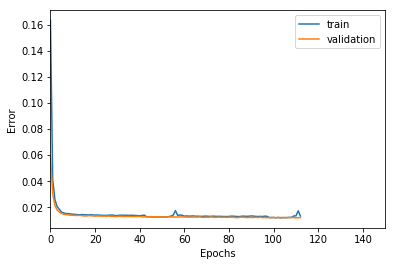

Training loss for final epoch is 0.013416780584026127
Validation loss for final epoch is 0.012254659853642807
---------- Beginning tests for lin2 ----------
Testing on Normal data.
The mean error for lin2_normal_ is 0.012387422840360412 for length 68297





In [44]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 5 steps

In [45]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin5"

In [46]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [47]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

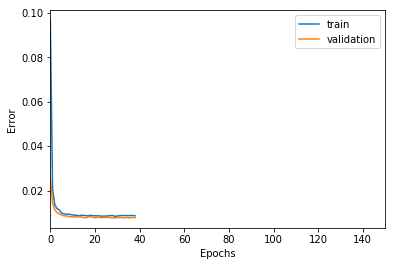

Training loss for final epoch is 0.008614786661812104
Validation loss for final epoch is 0.007737001340603456
---------- Beginning tests for lin5 ----------
Testing on Normal data.
The mean error for lin5_normal_ is 0.00787788306863858 for length 68294





In [48]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 10 steps

In [42]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin10"

In [43]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [44]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

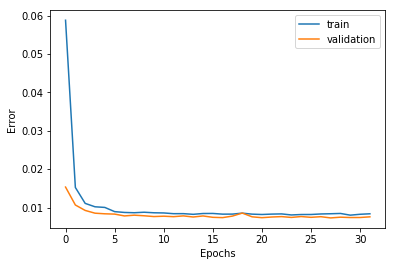

Training loss for final epoch is 0.008366131564718672
Validation loss for final epoch is 0.007570289019728079


In [45]:
train(model, tgen, vgen, name=name)

---------- Beginning tests for lin10 ----------


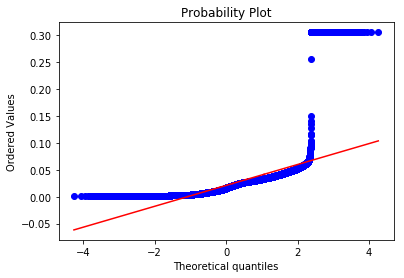

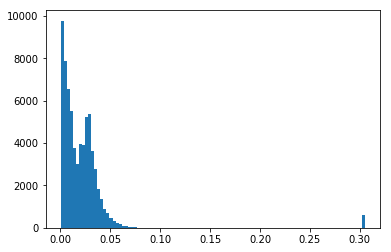

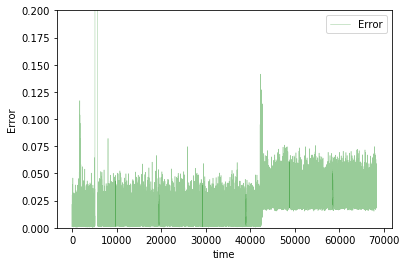

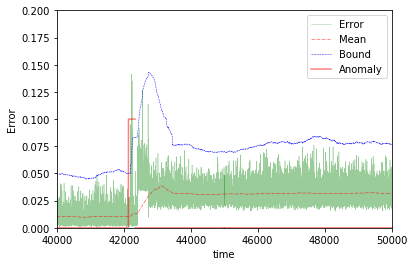

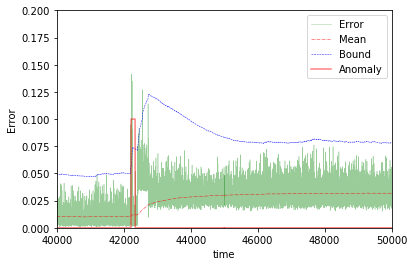

The mean error for lin10_disk_IO_start_ is 0.02098206533729859 for length 68289


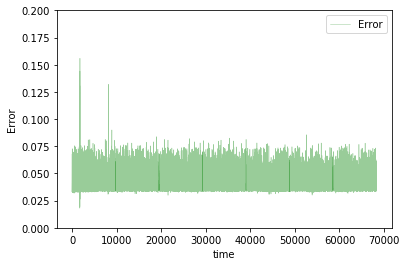

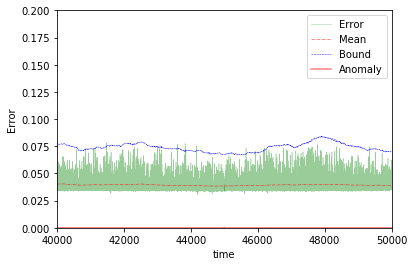

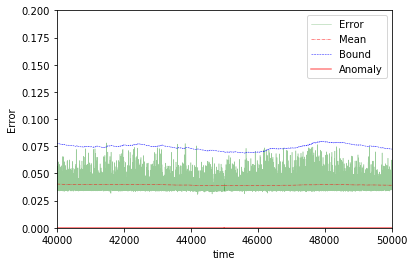

The mean error for lin10_avg_load_ is 0.03970266988464228 for length 68289


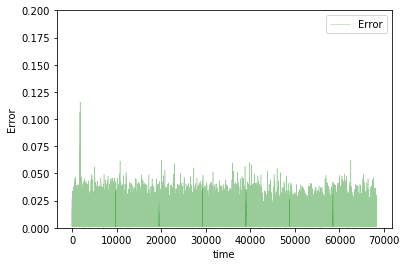

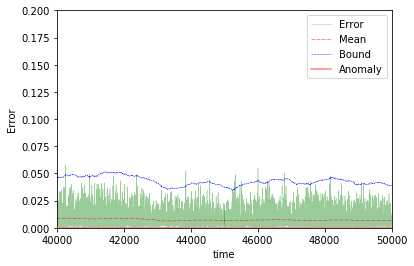

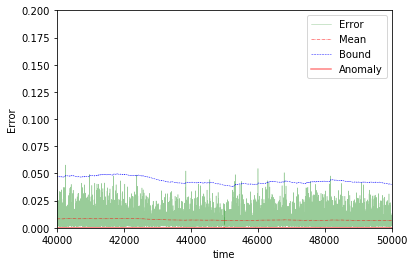

The mean error for lin10_normal_ is 0.007663399022936822 for length 68289





In [49]:
test(model, name=name, window=TIMESTEPS)

#### 20 steps

In [53]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin20"

In [54]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [55]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

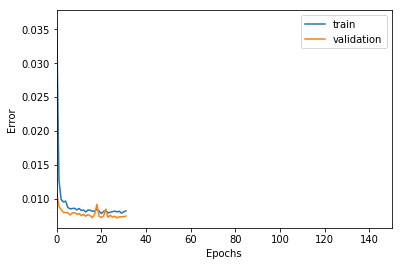

Training loss for final epoch is 0.008191164544317871
Validation loss for final epoch is 0.0074185703984694555
---------- Beginning tests for lin20 ----------
Testing on Normal data.
The mean error for lin20_normal_ is 0.0073792219066618715 for length 68279





In [56]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 50 steps

In [57]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin50"

In [58]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [59]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

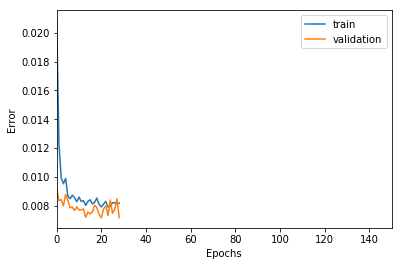

Training loss for final epoch is 0.00817395983391907
Validation loss for final epoch is 0.0071694665958639235
---------- Beginning tests for lin50 ----------
Testing on Normal data.
The mean error for lin50_normal_ is 0.007249869072372127 for length 68249





In [60]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 100 steps

In [61]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin100"

In [62]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [63]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

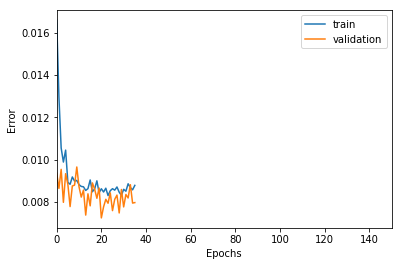

Training loss for final epoch is 0.008786280363216065
Validation loss for final epoch is 0.007973676408873871
---------- Beginning tests for lin100 ----------
Testing on Normal data.
The mean error for lin100_normal_ is 0.008220285709627795 for length 68199





In [64]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 200 steps

In [65]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "lin200"

In [66]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
output = Dense(DIM, activation='sigmoid')(input_layer)

In [67]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

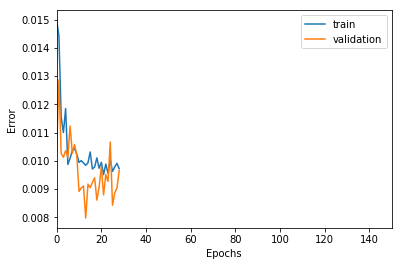

Training loss for final epoch is 0.009722595837665722
Validation loss for final epoch is 0.009655365781858563
---------- Beginning tests for lin200 ----------
Testing on Normal data.
The mean error for lin200_normal_ is 0.009828603685320828 for length 68099





In [68]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

### NN with 1 hidden layer

#### 2 steps

In [69]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_2"

In [70]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [71]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

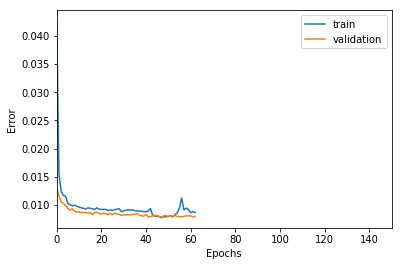

Training loss for final epoch is 0.008659293601755052
Validation loss for final epoch is 0.007953081339132041
---------- Beginning tests for nn1_2 ----------
Testing on Normal data.
The mean error for nn1_2_normal_ is 0.007994621592811366 for length 68297





In [72]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 5 steps

In [73]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_5"

In [74]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [75]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

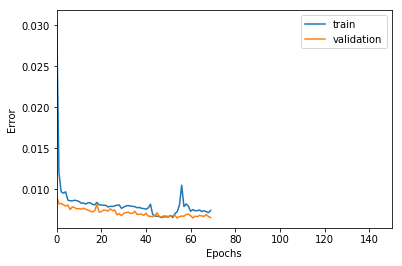

Training loss for final epoch is 0.007452224144013598
Validation loss for final epoch is 0.006576215894776396
---------- Beginning tests for nn1_5 ----------
Testing on Normal data.
The mean error for nn1_5_normal_ is 0.0068011005026057565 for length 68294





In [76]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 10 steps

In [77]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_10"

In [78]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [79]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

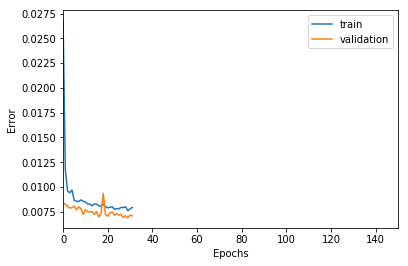

Training loss for final epoch is 0.00793381834810134
Validation loss for final epoch is 0.007084297833265737
---------- Beginning tests for nn1_10 ----------
Testing on Normal data.
The mean error for nn1_10_normal_ is 0.0071015961934418085 for length 68289





In [80]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 20 steps

In [81]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_20"

In [82]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100,activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [83]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

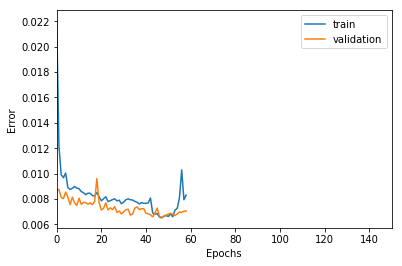

Training loss for final epoch is 0.008313262965297327
Validation loss for final epoch is 0.0070471914840163664
---------- Beginning tests for nn1_20 ----------
Testing on Normal data.
The mean error for nn1_20_normal_ is 0.007033562767864598 for length 68279





In [84]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 50 steps

In [85]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_50"

In [86]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100,activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [87]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

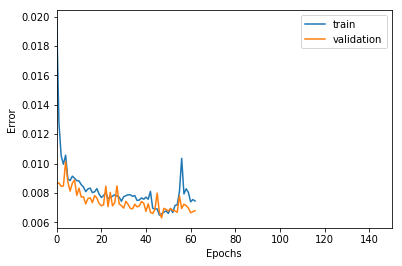

Training loss for final epoch is 0.007449903451837599
Validation loss for final epoch is 0.0067869715732522306
---------- Beginning tests for nn1_50 ----------
Testing on Normal data.
The mean error for nn1_50_normal_ is 0.006877856114368052 for length 68249





In [88]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 100 steps

In [89]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_100"

In [90]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100,activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [91]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

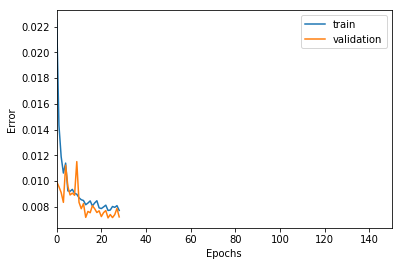

Training loss for final epoch is 0.007719434232800268
Validation loss for final epoch is 0.007220762135460973
---------- Beginning tests for nn1_100 ----------
Testing on Normal data.
The mean error for nn1_100_normal_ is 0.00760213146233752 for length 68199





In [92]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 200 steps

In [93]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn1_200"

In [94]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(100,activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [95]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

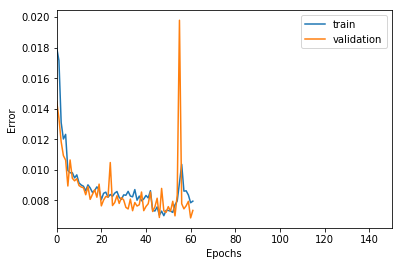

Training loss for final epoch is 0.007950572421657852
Validation loss for final epoch is 0.007343811719561927
---------- Beginning tests for nn1_200 ----------
Testing on Normal data.
The mean error for nn1_200_normal_ is 0.0072501510127501835 for length 68099





In [96]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

### NN with 2 hidden layers

#### 2 steps

In [97]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_2"

In [98]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [99]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

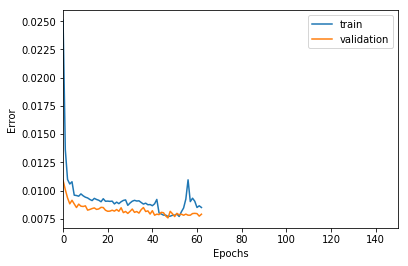

Training loss for final epoch is 0.008498040453880093
Validation loss for final epoch is 0.007903993673389778
---------- Beginning tests for nn2_2 ----------
Testing on Normal data.
The mean error for nn2_2_normal_ is 0.007917596801797305 for length 68297





In [100]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 5 steps

In [101]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_5"

In [102]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [103]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

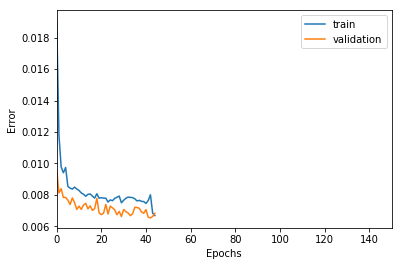

Training loss for final epoch is 0.0066789969558594744
Validation loss for final epoch is 0.006827179183368571
---------- Beginning tests for nn2_5 ----------
Testing on Normal data.
The mean error for nn2_5_normal_ is 0.006986421763700156 for length 68294





In [104]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 10 steps

In [105]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_10"

In [106]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [107]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

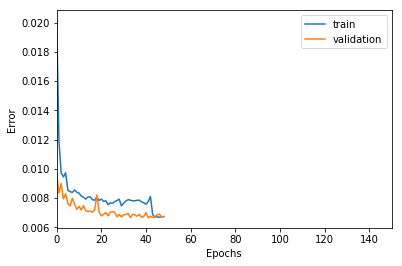

Training loss for final epoch is 0.0067363902067299935
Validation loss for final epoch is 0.006736550310859456
---------- Beginning tests for nn2_10 ----------
Testing on Normal data.
The mean error for nn2_10_normal_ is 0.006884008741104461 for length 68289





In [108]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 20 steps

In [109]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_20"

In [110]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [111]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

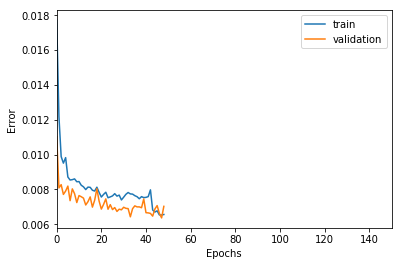

Training loss for final epoch is 0.006559579807100818
Validation loss for final epoch is 0.007027862660354003
---------- Beginning tests for nn2_20 ----------
Testing on Normal data.
The mean error for nn2_20_normal_ is 0.007108491733623256 for length 68279





In [112]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 50 steps

In [113]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_50"

In [114]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [115]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

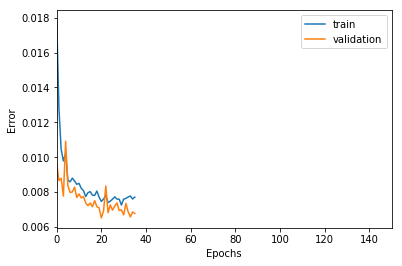

Training loss for final epoch is 0.007712966272374615
Validation loss for final epoch is 0.006775653469841927
---------- Beginning tests for nn2_50 ----------
Testing on Normal data.
The mean error for nn2_50_normal_ is 0.006815644721617581 for length 68249





In [116]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 100 steps

In [117]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_100"

In [118]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [119]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

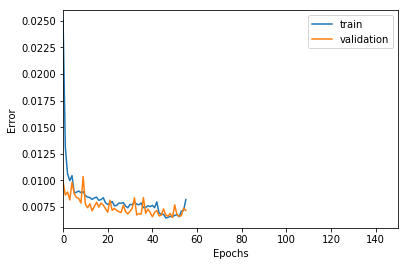

Training loss for final epoch is 0.008214631992275827
Validation loss for final epoch is 0.007188862114795484
---------- Beginning tests for nn2_100 ----------
Testing on Normal data.
The mean error for nn2_100_normal_ is 0.007177753335801814 for length 68199





In [120]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 200 steps

In [121]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn2_200"

In [122]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(500, activation='relu')(input_layer)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [123]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

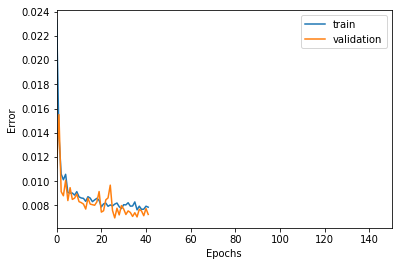

Training loss for final epoch is 0.00785774312983267
Validation loss for final epoch is 0.007260691675008275
---------- Beginning tests for nn2_200 ----------
Testing on Normal data.
The mean error for nn2_200_normal_ is 0.007535979158200196 for length 68099





In [124]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

### NN with 3 hidden layers

#### 2 steps

In [125]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_2"

In [126]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [127]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

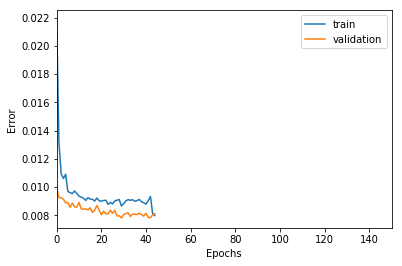

Training loss for final epoch is 0.007967605119105428
Validation loss for final epoch is 0.008109678512904794
---------- Beginning tests for nn3_2 ----------
Testing on Normal data.
The mean error for nn3_2_normal_ is 0.00834088251664893 for length 68297





In [128]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 5 steps

In [129]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_5"

In [130]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [131]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

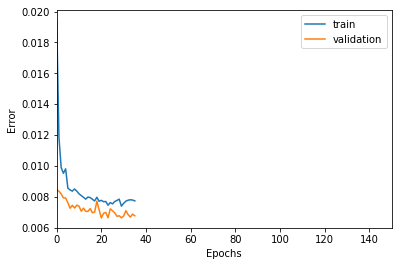

Training loss for final epoch is 0.0077323188508162275
Validation loss for final epoch is 0.006765582909691147
---------- Beginning tests for nn3_5 ----------
Testing on Normal data.
The mean error for nn3_5_normal_ is 0.006954202823170684 for length 68294





In [132]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 10 steps

In [133]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_10"

In [134]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [135]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

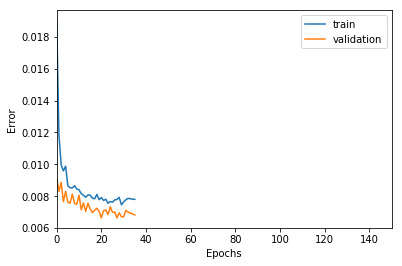

Training loss for final epoch is 0.007804850130574778
Validation loss for final epoch is 0.006826548885670491
---------- Beginning tests for nn3_10 ----------
Testing on Normal data.
The mean error for nn3_10_normal_ is 0.007050310612876376 for length 68289





In [136]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 20 steps

In [137]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_20"

In [138]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [139]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

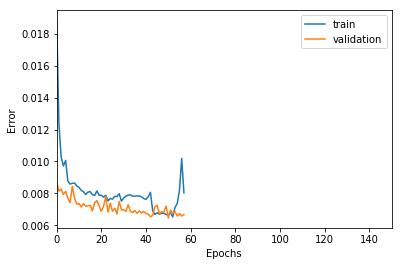

Training loss for final epoch is 0.00803304539679084
Validation loss for final epoch is 0.006671784618869424
---------- Beginning tests for nn3_20 ----------
Testing on Normal data.
The mean error for nn3_20_normal_ is 0.007110295118845597 for length 68279





In [140]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 50 steps

In [141]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_50"

In [142]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [143]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

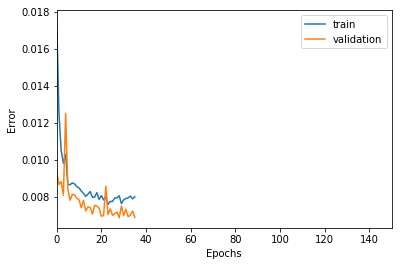

Training loss for final epoch is 0.00800238908524625
Validation loss for final epoch is 0.0068953298605047165
---------- Beginning tests for nn3_50 ----------
Testing on Normal data.
The mean error for nn3_50_normal_ is 0.007024872893617079 for length 68249





In [144]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 100 steps

In [145]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_100"

In [146]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [147]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

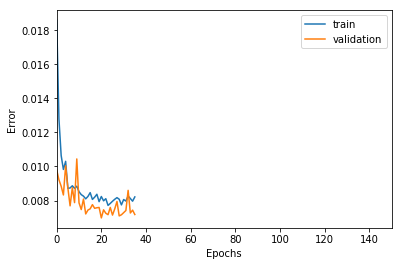

Training loss for final epoch is 0.008213097173720598
Validation loss for final epoch is 0.007180382827762515
---------- Beginning tests for nn3_100 ----------
Testing on Normal data.
The mean error for nn3_100_normal_ is 0.007391991955082882 for length 68199





In [148]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

#### 200 steps

In [149]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS)
vgen = flat_generator(val_X, TIMESTEPS)
name = "nn3_200"

In [150]:
input_layer = Input(shape=(TIMESTEPS*DIM,))
hidden = Dense(1000, activation='relu')(input_layer)
hidden = Dense(500, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [151]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

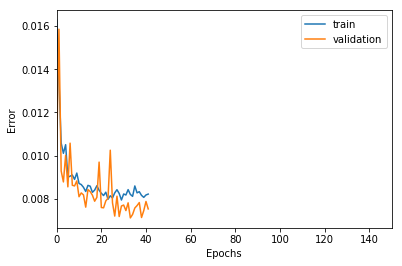

Training loss for final epoch is 0.008216266793315299
Validation loss for final epoch is 0.007529144670930691
---------- Beginning tests for nn3_200 ----------
Testing on Normal data.
The mean error for nn3_200_normal_ is 0.007869367744395585 for length 68099





In [152]:
train(model, tgen, vgen, name=name)
test(model, name=name, window=TIMESTEPS)

### RNN with 1 GRU layers

#### 2 steps

In [153]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru1_2"

In [154]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [155]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

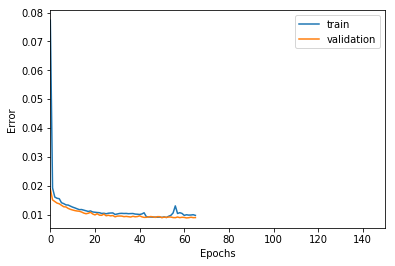

Training loss for final epoch is 0.009706683627562598
Validation loss for final epoch is 0.008947467094752937
---------- Beginning tests for gru1_2 ----------
Testing on Normal data.
The mean error for gru1_2_normal_ is 0.008993862685591608 for length 68297





In [156]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 5 steps

In [157]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS, 0)
name = "gru1_5"

In [158]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [159]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

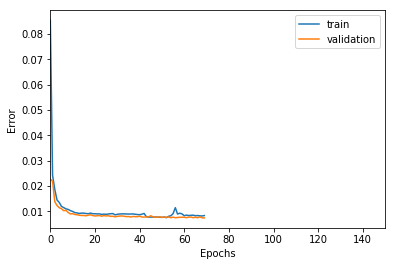

Training loss for final epoch is 0.008296772385830991
Validation loss for final epoch is 0.0073729068447137254
---------- Beginning tests for gru1_5 ----------
Testing on Normal data.
The mean error for gru1_5_normal_ is 0.007549772136475193 for length 68294





In [160]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 10 steps

In [161]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS, 0)
vgen = flat_generator(val_X, TIMESTEPS, 0)
name = "gru1_10"

In [162]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [163]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

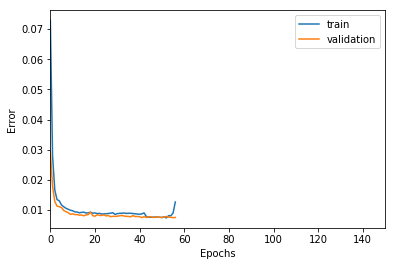

Training loss for final epoch is 0.012652858572313562
Validation loss for final epoch is 0.007511475227773189
---------- Beginning tests for gru1_10 ----------
Testing on Normal data.
The mean error for gru1_10_normal_ is 0.007927752853726001 for length 68289





In [164]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 20 steps

In [165]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru1_20"

In [166]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [167]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

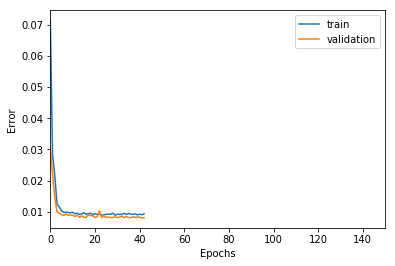

Training loss for final epoch is 0.009339298318489455
Validation loss for final epoch is 0.008080611640121789
---------- Beginning tests for gru1_20 ----------
Testing on Normal data.
The mean error for gru1_20_normal_ is 0.008391362892298393 for length 68279





In [168]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 50 steps

In [169]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru1_50"

In [170]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [171]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

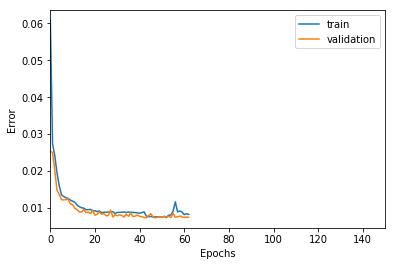

Training loss for final epoch is 0.008299405021243728
Validation loss for final epoch is 0.007497074310318567
---------- Beginning tests for gru1_50 ----------
Testing on Normal data.
The mean error for gru1_50_normal_ is 0.007770220456521439 for length 68249





In [172]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 100 steps

In [173]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru1_100"

In [174]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [175]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

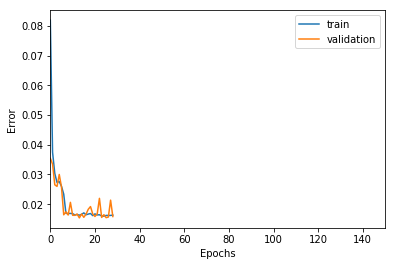

Training loss for final epoch is 0.01631342939264141
Validation loss for final epoch is 0.01585128901596181
---------- Beginning tests for gru1_100 ----------
Testing on Normal data.
The mean error for gru1_100_normal_ is 0.016431981388441395 for length 68199





In [176]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 200 steps

In [177]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru1_200"

In [178]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu')(input_layer)
output = Dense(DIM, activation='sigmoid')(hidden)

In [179]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

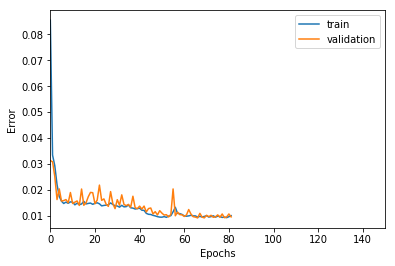

Training loss for final epoch is 0.010022789542097598
Validation loss for final epoch is 0.009562388401012869
---------- Beginning tests for gru1_200 ----------
Testing on Normal data.
The mean error for gru1_200_normal_ is 0.010689449162389751 for length 68099





In [180]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

### RNN with 2 GRU layers

#### 2 steps

In [181]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru2_2"

In [182]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [183]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

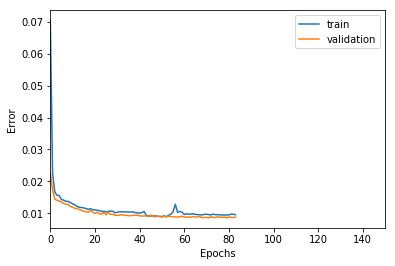

Training loss for final epoch is 0.009525582371163181
Validation loss for final epoch is 0.008728021897375584
---------- Beginning tests for gru2_2 ----------
Testing on Normal data.
The mean error for gru2_2_normal_ is 0.009121337264530432 for length 68297





In [184]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 5 steps

In [185]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS, 0)
name = "gru2_5"

In [186]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [187]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

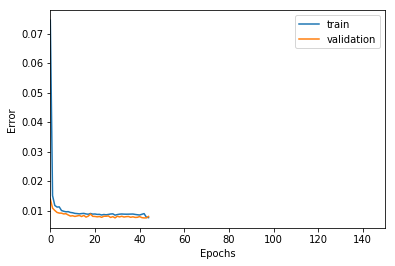

Training loss for final epoch is 0.007584470974630676
Validation loss for final epoch is 0.007987136821029708
---------- Beginning tests for gru2_5 ----------
Testing on Normal data.
The mean error for gru2_5_normal_ is 0.008080197580486092 for length 68294





In [188]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 10 steps

In [189]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS, 0)
vgen = flat_generator(val_X, TIMESTEPS, 0)
name = "gru2_10"

In [190]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [191]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

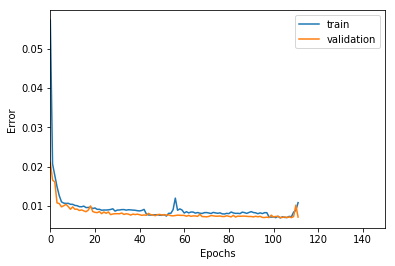

Training loss for final epoch is 0.010848661084892228
Validation loss for final epoch is 0.007174341501900926
---------- Beginning tests for gru2_10 ----------
Testing on Normal data.
The mean error for gru2_10_normal_ is 0.0076239894978364035 for length 68289





In [192]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 20 steps

In [193]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru2_20"

In [194]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [195]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

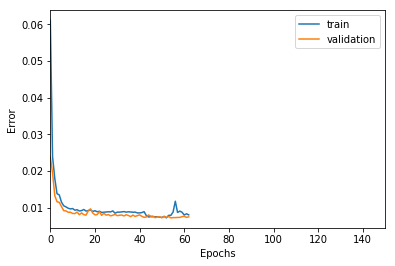

Training loss for final epoch is 0.008011758126784115
Validation loss for final epoch is 0.007475883128354326
---------- Beginning tests for gru2_20 ----------
Testing on Normal data.
The mean error for gru2_20_normal_ is 0.007807341381850342 for length 68279





In [196]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 50 steps

In [197]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru2_50"

In [198]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [199]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

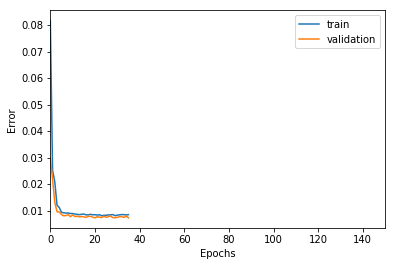

Training loss for final epoch is 0.008501599075389095
Validation loss for final epoch is 0.007305883733206429
---------- Beginning tests for gru2_50 ----------
Testing on Normal data.
The mean error for gru2_50_normal_ is 0.007478376398318241 for length 68249





In [200]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 100 steps

In [201]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru2_100"

In [202]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [203]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

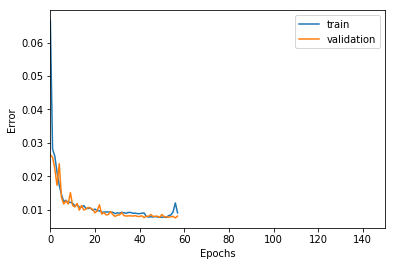

Training loss for final epoch is 0.009000581403728574
Validation loss for final epoch is 0.00802975850342773
---------- Beginning tests for gru2_100 ----------
Testing on Normal data.
The mean error for gru2_100_normal_ is 0.00790599778056267 for length 68199





In [204]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 200 steps

In [205]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru2_200"

In [206]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [207]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

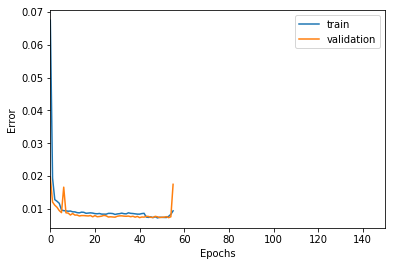

Training loss for final epoch is 0.009445819566608407
Validation loss for final epoch is 0.017511844133026897
---------- Beginning tests for gru2_200 ----------
Testing on Normal data.
The mean error for gru2_200_normal_ is 0.018348760026304353 for length 68099





In [208]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

### RNN with 3 GRU layers

#### 2 steps

In [209]:
TIMESTEPS = 2
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru3_2"

In [210]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [211]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

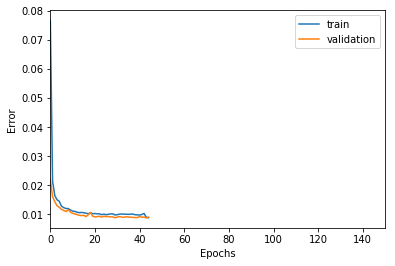

Training loss for final epoch is 0.008843629790702835
Validation loss for final epoch is 0.009052777277538553
---------- Beginning tests for gru3_2 ----------
Testing on Normal data.
The mean error for gru3_2_normal_ is 0.009473623802419293 for length 68297





In [212]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 5 steps

In [213]:
TIMESTEPS = 5
DIM = 29
tgen = flat_generator(X, TIMESTEPS, 0)
vgen = flat_generator(val_X, TIMESTEPS, 0)
name = "gru3_5"

In [214]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [215]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

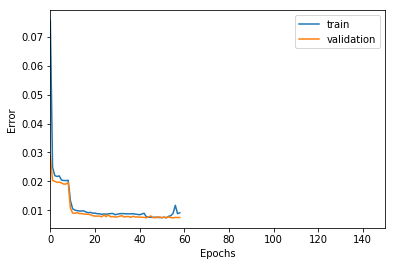

Training loss for final epoch is 0.009115311296773143
Validation loss for final epoch is 0.0074810532400151715
---------- Beginning tests for gru3_5 ----------
Testing on Normal data.
The mean error for gru3_5_normal_ is 0.0075476083905910395 for length 68294





In [216]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 10 steps

In [217]:
TIMESTEPS = 10
DIM = 29
tgen = flat_generator(X, TIMESTEPS, 0)
vgen = flat_generator(val_X, TIMESTEPS, 0)
name = "gru3_10"

In [218]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [219]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

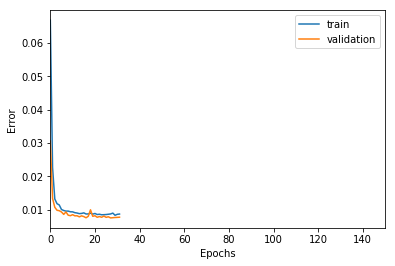

Training loss for final epoch is 0.008746968768769875
Validation loss for final epoch is 0.007804992166813463
---------- Beginning tests for gru3_10 ----------
Testing on Normal data.
The mean error for gru3_10_normal_ is 0.007801755871874415 for length 68289





In [220]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 20 steps

In [221]:
TIMESTEPS = 20
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru3_20"

In [222]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [223]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

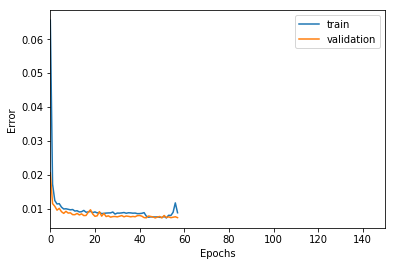

Training loss for final epoch is 0.008760190748842434
Validation loss for final epoch is 0.0073154288076329975
---------- Beginning tests for gru3_20 ----------
Testing on Normal data.
The mean error for gru3_20_normal_ is 0.007688186565486547 for length 68279





In [224]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 50 steps

In [225]:
TIMESTEPS = 50
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru3_50"

In [226]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [227]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

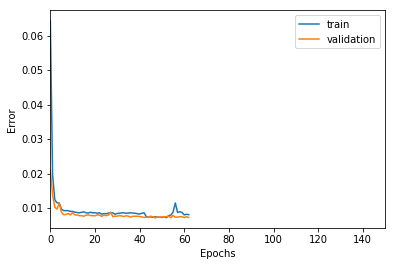

Training loss for final epoch is 0.008108793774968944
Validation loss for final epoch is 0.007307445683283732
---------- Beginning tests for gru3_50 ----------
Testing on Normal data.
The mean error for gru3_50_normal_ is 0.007553005030857614 for length 68249





In [228]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 100 steps

In [229]:
TIMESTEPS = 100
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru3_100"

In [230]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [231]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

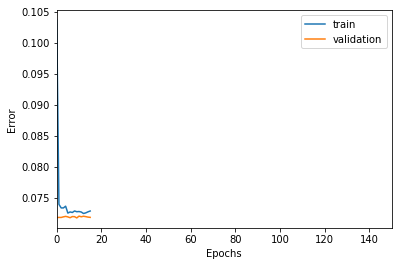

Training loss for final epoch is 0.07286714933440089
Validation loss for final epoch is 0.07184143787622452
---------- Beginning tests for gru3_100 ----------
Testing on Normal data.
The mean error for gru3_100_normal_ is 0.07120430445496657 for length 68199





In [232]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)

#### 200 steps

In [233]:
TIMESTEPS = 200
DIM = 29
tgen = flat_generator(X, TIMESTEPS,0)
vgen = flat_generator(val_X, TIMESTEPS,0)
name = "gru3_200"

In [234]:
input_layer = Input(shape=(TIMESTEPS,DIM))
hidden = GRU(10, activation='relu', return_sequences=True)(input_layer)
hidden = GRU(10, activation='relu', return_sequences=True)(hidden)
hidden = GRU(10, activation='relu')(hidden)
output = Dense(DIM, activation='sigmoid')(hidden)

In [235]:
model = Model(input_layer, output)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae'])

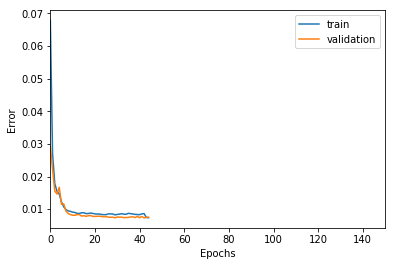

Training loss for final epoch is 0.007368435216718353
Validation loss for final epoch is 0.007526277523837052
---------- Beginning tests for gru3_200 ----------
Testing on Normal data.
The mean error for gru3_200_normal_ is 0.007548149244849392 for length 68099





In [236]:
train(model, tgen, vgen, name=name)
test(model, ravel=0, name=name, window=TIMESTEPS)